> Imports 

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler




In [2]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\AVG_Gas.csv")
df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)


 Sliding Window Cross-Validation (Fixed Window)

In [ ]:

def strict_expanding_window_validation(
    df, features, target_col, model_fn, forecast_horizon=3
):
    n = len(df)
    test_start = int(n * 0.85)
    val_start = int(n * 0.75)

    X = df[features].values
    y = df[target_col].values

    val_preds, val_actuals, val_dates = [], [], []
    for i in range(val_start, test_start - forecast_horizon + 1):
        X_train = X[:i]
        y_train = y[:i]
        X_val = X[i:i+forecast_horizon]
        y_val = y[i:i+forecast_horizon]

        model = model_fn()
        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        val_preds.extend(preds)
        val_actuals.extend(y_val)
        val_dates.extend(df.iloc[i:i+forecast_horizon]['Periode'].values)

    test_preds, test_actuals, test_dates = [], [], []
    for i in range(test_start, n - forecast_horizon + 1):
        X_train = X[:i]
        y_train = y[:i]
        X_test = X[i:i+forecast_horizon]
        y_test = y[i:i+forecast_horizon]

        model = model_fn()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        test_preds.extend(preds)
        test_actuals.extend(y_test)
        test_dates.extend(df.iloc[i:i+forecast_horizon]['Periode'].values)

    return {
        "val_mae": mean_absolute_error(val_actuals, val_preds),
        "val_rmse": np.sqrt(mean_squared_error(val_actuals, val_preds)),
        "val_r2": r2_score(val_actuals, val_preds),
        "val_mape": mean_absolute_percentage_error(val_actuals, val_preds),
        "val_preds": np.array(val_preds),
        "val_actuals": np.array(val_actuals),
        "val_dates": np.array(val_dates),
        "test_mae": mean_absolute_error(test_actuals, test_preds),
        "test_rmse": np.sqrt(mean_squared_error(test_actuals, test_preds)),
        "test_r2": r2_score(test_actuals, test_preds),
        "test_mape": mean_absolute_percentage_error(test_actuals, test_preds),
        "test_preds": np.array(test_preds),
        "test_actuals": np.array(test_actuals),
        "test_dates": np.array(test_dates)
    }
    

Train size: 162
Validation size: 22
Test size: 33
Train period: 2007-01-01 00:00:00 to 2020-06-01 00:00:00
Validation period: 2020-07-01 00:00:00 to 2022-04-01 00:00:00
Test period: 2022-05-01 00:00:00 to 2025-01-01 00:00:00


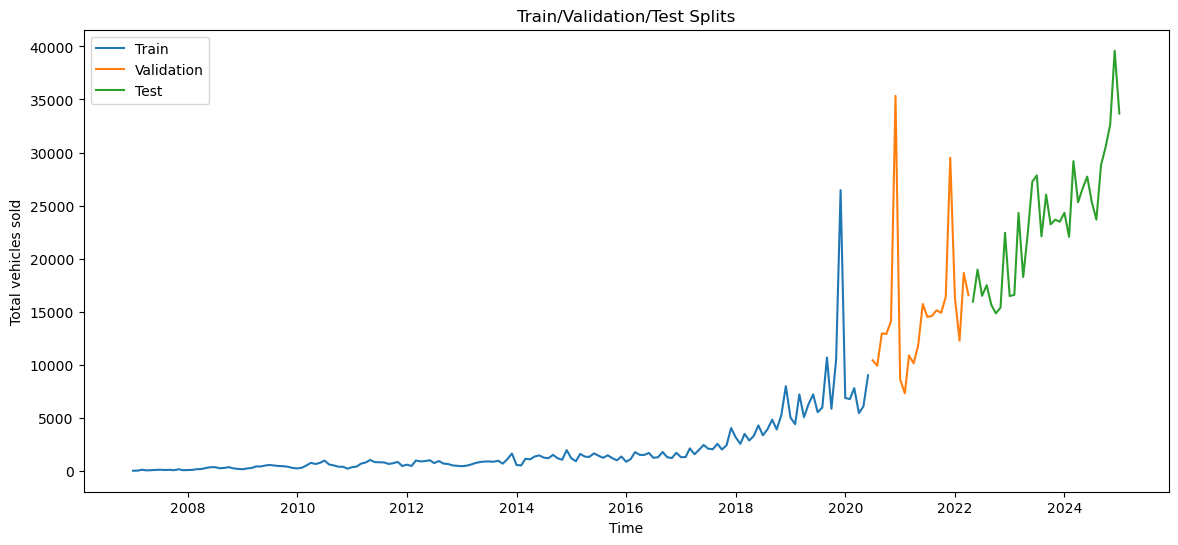

In [13]:
# Calculate train, validation, and test indices
n = len(df)
test_start = int(n * 0.85)
val_start = int(n * 0.75)

train_idx = np.arange(0, val_start)
val_idx = np.arange(val_start, test_start)
test_idx = np.arange(test_start, n)

# Print sizes
print(f"Train size: {len(train_idx)}")
print(f"Validation size: {len(val_idx)}")
print(f"Test size: {len(test_idx)}")

# Print first and last date for each split
print(f"Train period: {df.iloc[train_idx[0]]['Time Period (T)']} to {df.iloc[train_idx[-1]]['Time Period (T)']}")
print(f"Validation period: {df.iloc[val_idx[0]]['Time Period (T)']} to {df.iloc[val_idx[-1]]['Time Period (T)']}")
print(f"Test period: {df.iloc[test_idx[0]]['Time Period (T)']} to {df.iloc[test_idx[-1]]['Time Period (T)']}")

# Plot splits
plt.figure(figsize=(14, 6))
plt.plot(df.loc[train_idx, "Time Period (T)"], df.loc[train_idx, "Total vehicles sold (Target)"], label="Train")
plt.plot(df.loc[val_idx, "Time Period (T)"], df.loc[val_idx, "Total vehicles sold (Target)"], label="Validation")
plt.plot(df.loc[test_idx, "Time Period (T)"], df.loc[test_idx, "Total vehicles sold (Target)"], label="Test")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("Train/Validation/Test Splits")
plt.legend()
plt.show()

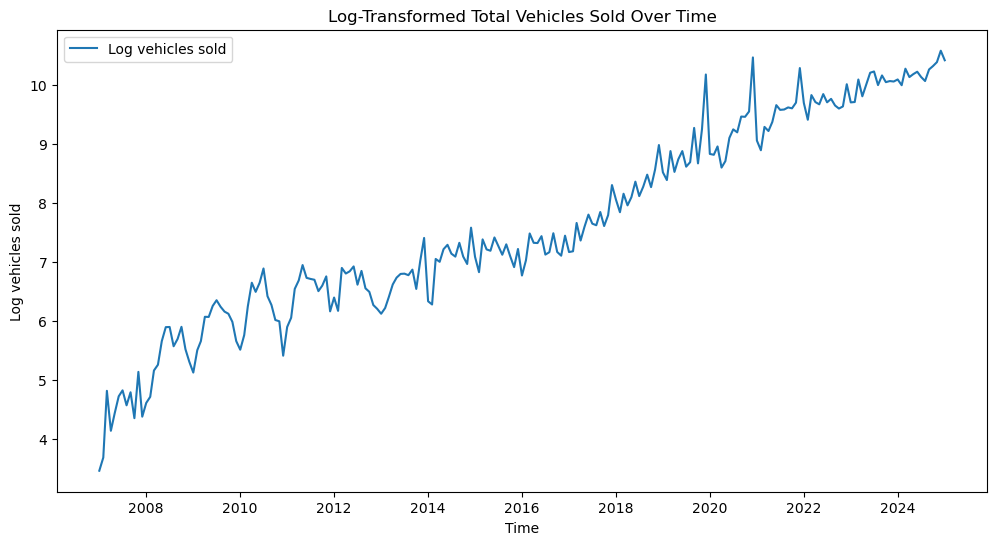

In [14]:
# Apply log transformation to the target variable in the dataframe
df['Log vehicles sold (Target)'] = np.log1p(df['Total vehicles sold (Target)'])

plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], df["Log vehicles sold (Target)"], label="Log vehicles sold")
plt.xlabel("Time")
plt.ylabel("Log vehicles sold")
plt.title("Log-Transformed Total Vehicles Sold Over Time")
plt.legend()
plt.show()

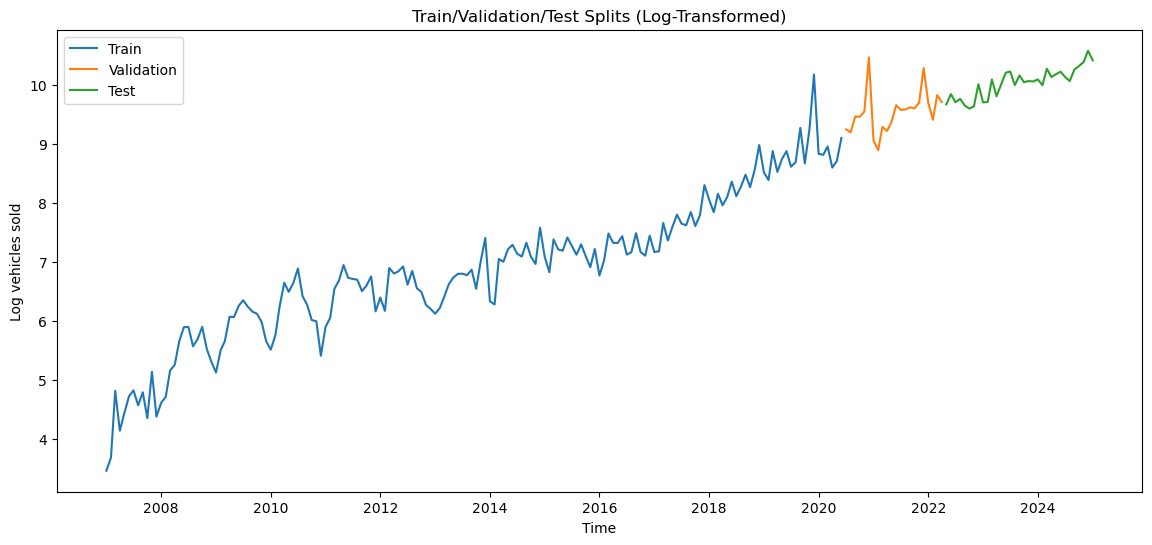

In [15]:
plt.figure(figsize=(14, 6))
plt.plot(df.loc[train_idx, "Time Period (T)"], df.loc[train_idx, "Log vehicles sold (Target)"], label="Train")
plt.plot(df.loc[val_idx, "Time Period (T)"], df.loc[val_idx, "Log vehicles sold (Target)"], label="Validation")
plt.plot(df.loc[test_idx, "Time Period (T)"], df.loc[test_idx, "Log vehicles sold (Target)"], label="Test")
plt.xlabel("Time")
plt.ylabel("Log vehicles sold")
plt.title("Train/Validation/Test Splits (Log-Transformed)")
plt.legend()
plt.show()

XGBoost RMSE: 9140.14
XGBoost MAE: 6979.69
XGBoost MAPE: 0.4222


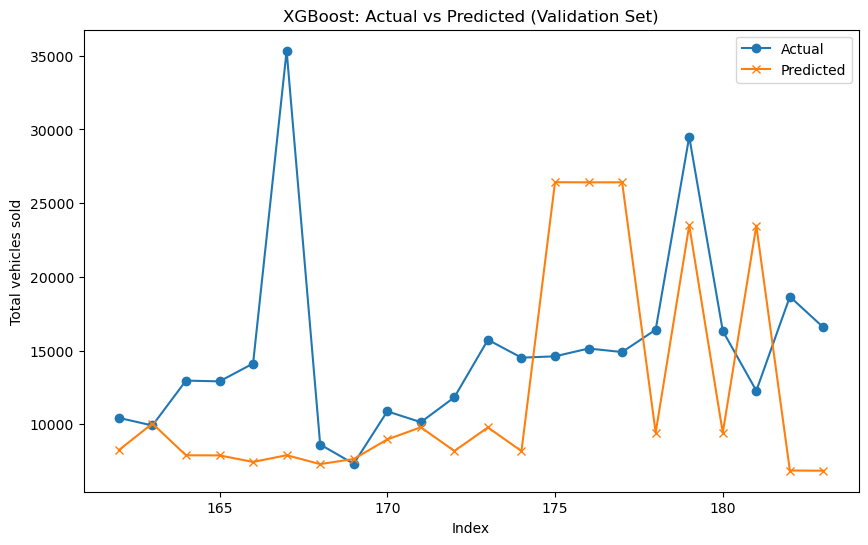

In [18]:
# Select features and target
features = [
    'Home charging (G)', 'Electric car (G)', 'Hybrid electric (G)',
    'Company car tax rate (%)', 'Consumer confidence (E)',
    'Economic climate perception (E)', 'Willingness to buy (E)',
    'Major purchases sentiment (E)', 'Gasoline (Euro95) - Average price (F)',
    'Diesel - Average price (F)'
]
target = 'Total vehicles sold (Target)'

# Prepare train and validation sets
X_train = df.loc[train_idx, features]
y_train = df.loc[train_idx, target]
X_val = df.loc[val_idx, features]
y_val = df.loc[val_idx, target]

# Train XGBoost regressor
xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict on validation set
y_pred = xgb_reg.predict(X_val)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost MAPE: {mape:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(y_val.index, y_val.values, label="Actual", marker="o")
plt.plot(y_val.index, y_pred, label="Predicted", marker="x")
plt.xlabel("Index")
plt.ylabel("Total vehicles sold")
plt.title("XGBoost: Actual vs Predicted (Validation Set)")
plt.legend()
plt.show()

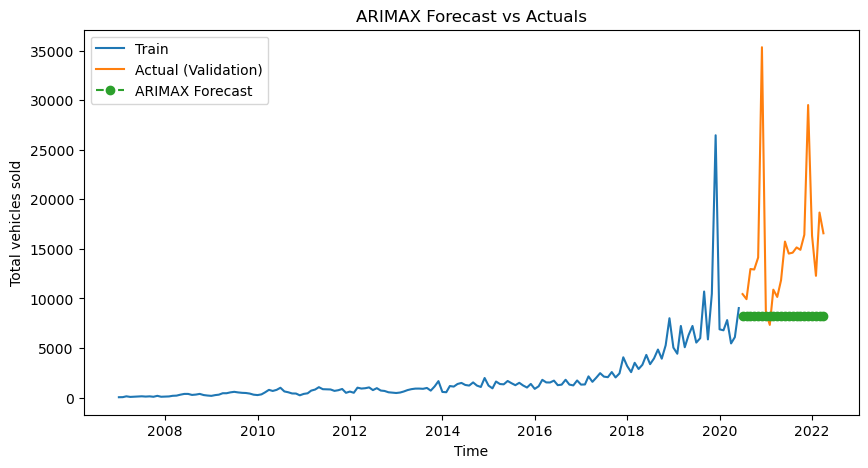

ARIMAX RMSE: 9188.62
ARIMAX MAPE: 0.3893


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use training data for the target variable only (univariate)
y_train = df.loc[train_idx, target]

# Fit ARIMAX (SARIMAX with no exogenous variables)
arimax_model = SARIMAX(y_train, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
arimax_result = arimax_model.fit()

# Forecast for the validation period
n_forecast = len(val_idx)
arimax_forecast = arimax_result.forecast(steps=n_forecast)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(df.loc[train_idx, "Time Period (T)"], y_train, label="Train")
plt.plot(df.loc[val_idx, "Time Period (T)"], df.loc[val_idx, target], label="Actual (Validation)")
plt.plot(df.loc[val_idx, "Time Period (T)"], arimax_forecast, label="ARIMAX Forecast", linestyle="--", marker="o")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("ARIMAX Forecast vs Actuals")
plt.legend()
plt.show()

# Calculate RMSE and MAPE for ARIMAX forecast
y_true = df.loc[val_idx, target]
rmse = np.sqrt(mean_squared_error(y_true, arimax_forecast))
mape = mean_absolute_percentage_error(y_true, arimax_forecast)

print(f"ARIMAX RMSE: {rmse:.2f}")
print(f"ARIMAX MAPE: {mape:.4f}")

In [16]:

# Suppose you have a DataFrame with a datetime index and target column 'y'
# Example: df['log_y'] contains your log-transformed series
y = df['log_y']

# Define ARIMA order: (p, d, q)
order = (2, 1, 1)  # Example: AR(2), differencing once, MA(1)

# Fit the ARIMA model (no exogenous variables)
model = SARIMAX(y, order=order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Print summary
print(results.summary())

# Predict in-sample or out-of-sample
# In-sample
y_pred = results.fittedvalues

# Forecast future steps
forecast_steps = 12
forecast = results.forecast(steps=forecast_steps)

# Plot
plt.plot(y, label='Observed')
plt.plot(y_pred, label='Fitted')
plt.plot(forecast.index, forecast.values, label='Forecast', linestyle='--')
plt.legend()
plt.show()

KeyError: 'log_y'

## Plotting the Data!

### Timeplot

 the obvious graph to start with is a time plot

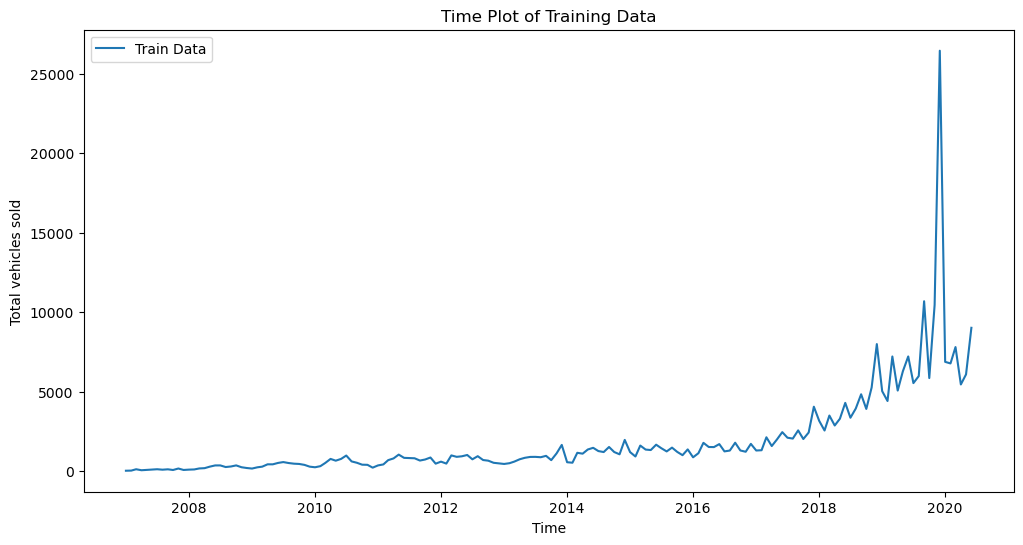

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df.loc[train_idx, "Time Period (T)"], df.loc[train_idx, "Total vehicles sold (Target)"], label="Train Data")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("Time Plot of Training Data")
plt.legend()
plt.show()

### Seasonal Plot

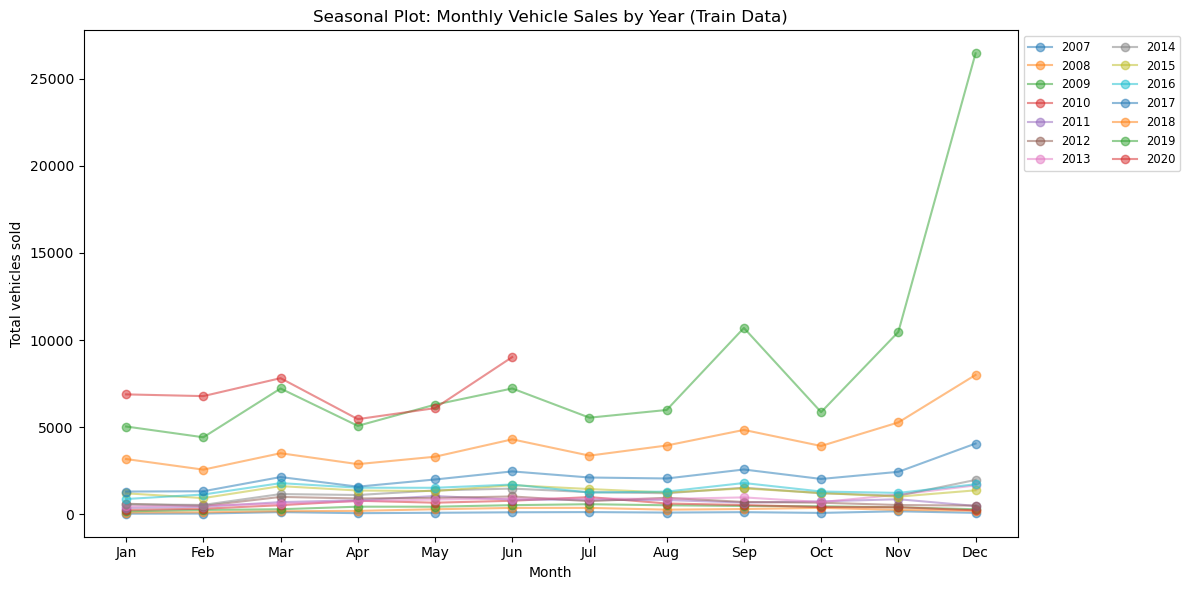

In [10]:
import calendar

train_df = df.loc[train_idx].copy()
train_df['Month'] = train_df['Time Period (T)'].dt.month
train_df['Year'] = train_df['Time Period (T)'].dt.year
train_df['MonthName'] = train_df['Month'].apply(lambda x: calendar.month_abbr[x])

plt.figure(figsize=(12, 6))
for year, group in train_df.groupby('Year'):
    plt.plot(group['MonthName'], group['Total vehicles sold (Target)'], marker='o', label=str(year), alpha=0.5)

plt.xlabel('Month')
plt.ylabel('Total vehicles sold')
plt.title('Seasonal Plot: Monthly Vehicle Sales by Year (Train Data)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize='small')
plt.tight_layout()
plt.show()


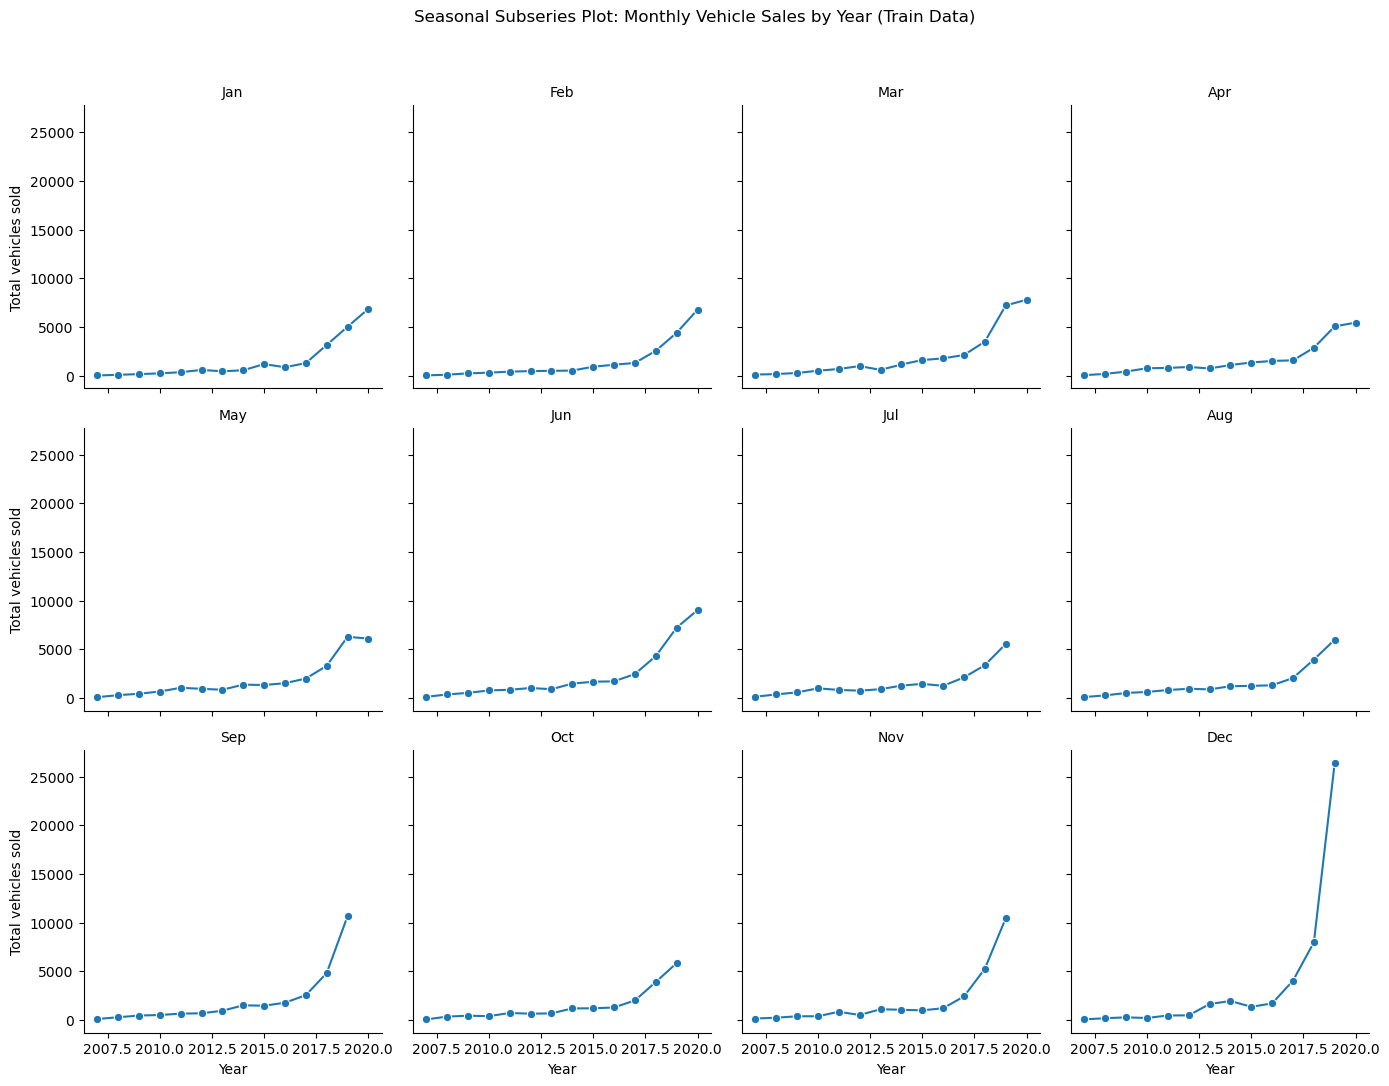

In [11]:
g = sns.FacetGrid(train_df, col="MonthName", col_wrap=4, sharey=True, height=3.5)
g.map_dataframe(
    sns.lineplot,
    x="Year",
    y="Total vehicles sold (Target)",
    marker="o",
    color="tab:blue"
)
g.set_axis_labels("Year", "Total vehicles sold")
g.set_titles(col_template="{col_name}")
g.fig.suptitle("Seasonal Subseries Plot: Monthly Vehicle Sales by Year (Train Data)", y=1.03)
plt.tight_layout()
plt.show()


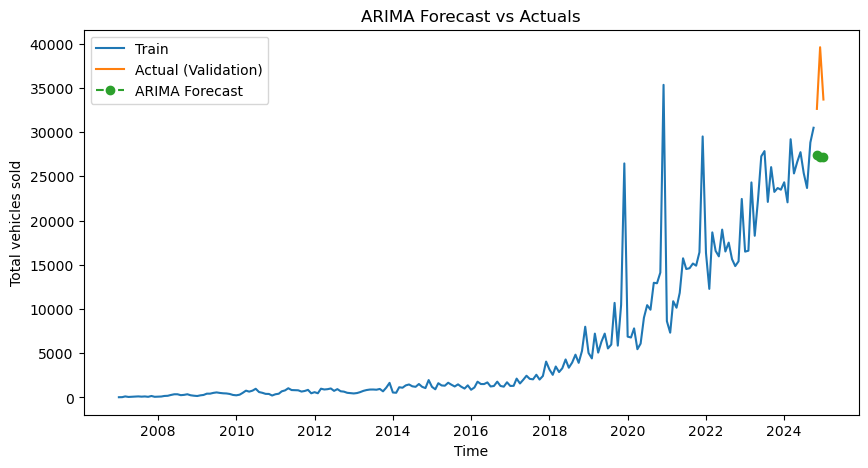

ARIMA RMSE: 8622.91
ARIMA MAPE: 0.2222


In [33]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on training data (univariate: only car sales)

# Use training data indices
y_train = df.loc[train_idx, "Total vehicles sold (Target)"]

# Fit ARIMA (order can be tuned; here (1,1,1) as a starting point)
arima_model = ARIMA(y_train, order=(1,1,1))
arima_result = arima_model.fit()

# Forecast for the validation period
n_forecast = len(val_idx)
arima_forecast = arima_result.forecast(steps=n_forecast)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(df.loc[train_idx, "Time Period (T)"], y_train, label="Train")
plt.plot(df.loc[val_idx, "Time Period (T)"], df.loc[val_idx, "Total vehicles sold (Target)"], label="Actual (Validation)")
plt.plot(df.loc[val_idx, "Time Period (T)"], arima_forecast, label="ARIMA Forecast", linestyle="--", marker="o")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("ARIMA Forecast vs Actuals")
plt.legend()
plt.show()

# Calculate RMSE and MAPE for ARIMA forecast
y_true = df.loc[val_idx, "Total vehicles sold (Target)"]
rmse = np.sqrt(mean_squared_error(y_true, arima_forecast))
mape = mean_absolute_percentage_error(y_true, arima_forecast)

print(f"ARIMA RMSE: {rmse:.2f}")
print(f"ARIMA MAPE: {mape:.4f}")